In [6]:
from transformers import AutoTokenizer, AutoModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from tqdm import tqdm

65
Embedding shape: torch.Size([1, 320])


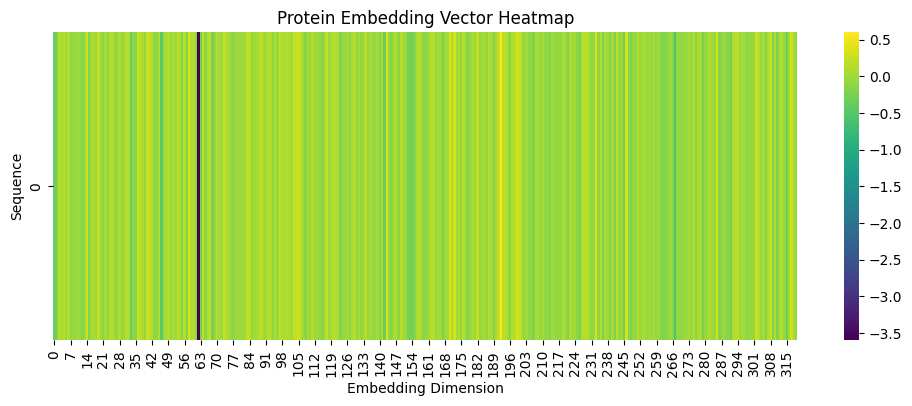

In [2]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D", add_pooling_layer=False)

sequence = "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"
print(len(sequence))

inputs = tokenizer(sequence, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

embeddings = outputs.last_hidden_state.mean(dim=1)

print(f"Embedding shape: {embeddings.shape}")

plt.figure(figsize=(12, 4))
sns.heatmap(embeddings.numpy(), cmap="viridis")
plt.title("Protein Embedding Vector Heatmap")
plt.xlabel("Embedding Dimension")
plt.ylabel("Sequence")
plt.show()

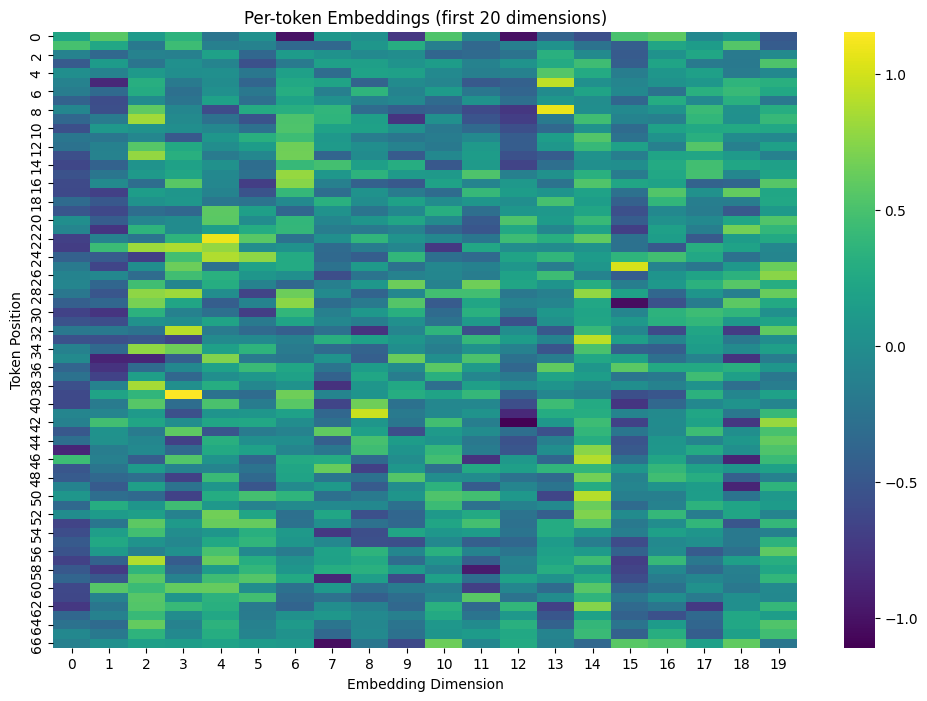

In [3]:
token_embeddings = outputs.last_hidden_state[0]

plt.figure(figsize=(12, 8))
sns.heatmap(token_embeddings.numpy()[:, :20], cmap="viridis")
plt.title("Per-token Embeddings (first 20 dimensions)")
plt.xlabel("Embedding Dimension")
plt.ylabel("Token Position")
plt.show()

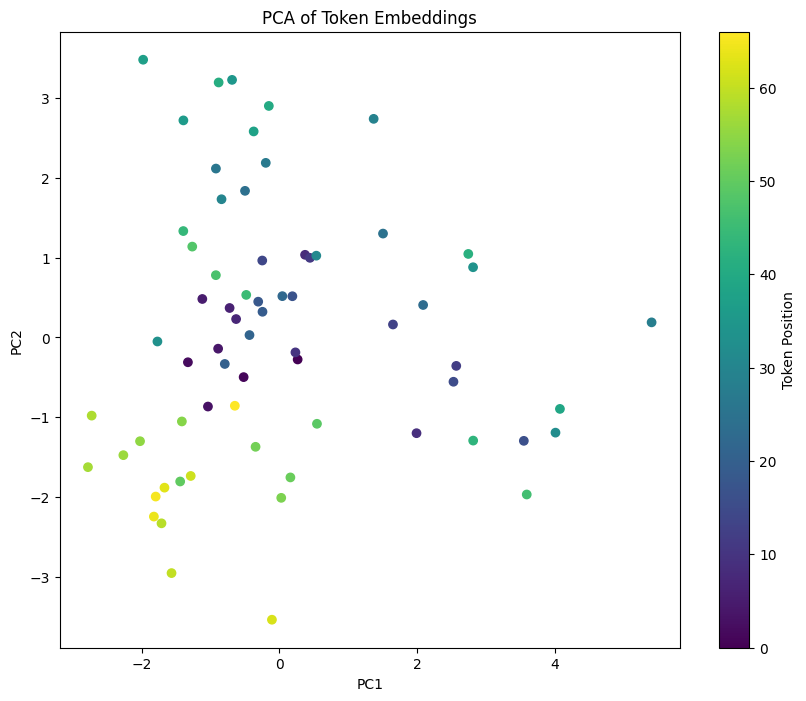

In [4]:
pca = PCA(n_components=2)
token_embeddings_2d = pca.fit_transform(token_embeddings.numpy())

plt.figure(figsize=(10, 8))
plt.scatter(
    token_embeddings_2d[:, 0],
    token_embeddings_2d[:, 1],
    c=np.arange(token_embeddings_2d.shape[0]),
    cmap="viridis",
)
plt.colorbar(label="Token Position")
plt.title("PCA of Token Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [5]:
# Unembedding the sequence
print("\nUnembedding the sequence:")
tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
amino_acids = [token.replace("<", "").replace(">", "") for token in tokens]
amino_acids = [aa for aa in amino_acids if aa not in ["cls", "pad", "eos", "mask"]]
unembedded_sequence = "".join(amino_acids)
print("Original sequence:", sequence)
print("Unembedded sequence:", unembedded_sequence)
print("Equal:", sequence == unembedded_sequence)


Unembedding the sequence:
Original sequence: MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG
Unembedded sequence: MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG
Equal: True


In [13]:
input_file = "protein_dataset.tsv"
output_file = "sequence_embeddings.csv"

df = pd.read_csv(f"../datasets/{input_file}", sep="\t")
print(f"Number of rows before removing duplicates: {len(df)}")

df = df[["UniProt_ID", "Protein_Sequence"]]
df = df.drop_duplicates(subset=["UniProt_ID"], keep="first")
print(f"Number of rows after removing duplicates: {len(df)}")

df.to_csv(output_file, index=False)
print(f"Unique protein data saved to {output_file}")

Number of rows before removing duplicates: 13154
Number of rows after removing duplicates: 289
Unique protein data saved to sequence_embeddings.csv


In [16]:
print("Loading protein language model and tokenizer...")
model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

print("Loading dataset...")
df = pd.read_csv(output_file)
print(f"Dataset loaded with {len(df)} rows containing protein sequences")


def generate_embedding(sequence):
    if not isinstance(sequence, str) or len(sequence) == 0:
        return None

    inputs = tokenizer(sequence, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()[0]
    return embedding


print("Generating embeddings for all proteins...")
embeddings = []
uniprot_ids = []
sequences = []
embedding_strings = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    uniprot_id = row["UniProt_ID"]
    sequence = row["Protein_Sequence"]

    embedding = generate_embedding(sequence)

    if embedding is not None:
        embeddings.append(embedding)
        uniprot_ids.append(uniprot_id)
        sequences.append(sequence)
        embedding_str = str(embedding)
        embedding_strings.append(embedding_str)

results_df = pd.DataFrame(
    {
        "UniProt_ID": uniprot_ids,
        "Protein_Sequence": sequences,
        "Embedding": embedding_strings,
    }
)

results_df.to_csv(output_file, index=False)

print(f"Completed! Generated embeddings for {len(embeddings)} proteins")
print(f"Embedding dimension: {len(embedding) if embeddings else 0}")
print(f"Results saved to {output_file}")

Loading protein language model and tokenizer...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu
Loading dataset...
Dataset loaded with 289 rows containing protein sequences
Generating embeddings for all proteins...


100%|██████████| 289/289 [00:19<00:00, 14.80it/s]

Completed! Generated embeddings for 289 proteins
Embedding dimension: 320
Results saved to sequence_embeddings.csv
